In [1]:
# General Dependencies
import os
import numpy as np

# Plotting & Video Rendering Dependencies
import matplotlib.pyplot as plt
from trefide.video import play_cv2
from funimag.plots import util_plot
from funimag import overlap_reduction

# Set Demo Dataset Location
ext = os.path.join("..", "example_movies")
filename = os.path.join(ext, "demoMovie.tif")

%load_ext autoreload
%autoreload 2

# Load Data

In [2]:
from skimage import io
mov = io.imread(filename).transpose([1,2,0])[:60,:60,:]
mov = np.asarray(mov,order='C',dtype=np.float64)
print(mov.shape)

fov_height, fov_width, num_frames = mov.shape

(60, 60, 2000)


# Load Denoised Data

In [3]:
data = np.load(os.path.join(ext, "demo_results.npz"))
U = data['arr_0']
V = data['arr_1']
mov_denoised = data['arr_2']
block_ranks = data['arr_3'][()]
block_height = data['arr_4']
block_width = data['arr_5']

# Compress overcomplete movie

In [5]:
dim1, dim2, ncomp = U.shape
Ur = U.reshape((dim1*dim2, ncomp))
nblocks = [fov_height//block_height, fov_width//block_width]

In [6]:
Ur, V, num_rejected = overlap_reduction.compression_rdx(nblocks, Ur, V, block_ranks)

Tile 0 from 9
Rejected 94 from 124


/home/ekb/Projects/matrixfactorization/funimag/funimag/overlap_reduction.py:42: RuntimeWarning: invalid value encountered in true_divide
  keep = np.argwhere((D1/n1) < l1tf_th).flatten()


Tile 1 from 9
Rejected 61 from 136
Tile 2 from 9
Rejected 37 from 87
Tile 3 from 9
Rejected 60 from 143
Tile 4 from 9
Rejected 39 from 147
Tile 5 from 9
Rejected 33 from 114
Tile 6 from 9
Rejected 46 from 118
Tile 7 from 9
Rejected 45 from 131
Tile 8 from 9
Rejected 26 from 100


## Calculate total rejected components

In [7]:
trim_idx = np.where(np.all(V==0,1))[0]
print('Total rejected %d out of %d'%(len(trim_idx),V.shape[0]))
Ur = np.delete(Ur, trim_idx, axis=1)
V = np.delete(V, trim_idx, axis=0)

Total rejected 441 out of 621


In [8]:
PU = np.linalg.pinv(Ur)
VPU = PU.dot(mov_denoised.reshape(fov_height*fov_width,num_frames))
mov_reduced = np.dot(Ur, VPU).reshape((fov_height,fov_width,num_frames))

# Produce Diagnostics

### Correlation Images

Local correlation:  range [2.1e-01 9.3e-01]
Local correlation:  range [6.0e-01 1.0e+00]
Local correlation:  range [-2.3e-01 2.5e-01]


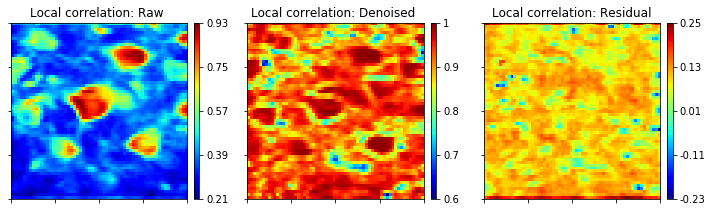

In [9]:
util_plot.comparison_plot([mov, mov_denoised + np.random.randn(np.prod(mov.shape)).reshape(mov.shape)*.01],
                plot_orientation="vertical")

Local correlation:  range [2.1e-01 9.3e-01]
Local correlation:  range [5.9e-01 1.0e+00]
Local correlation:  range [-2.2e-01 2.6e-01]


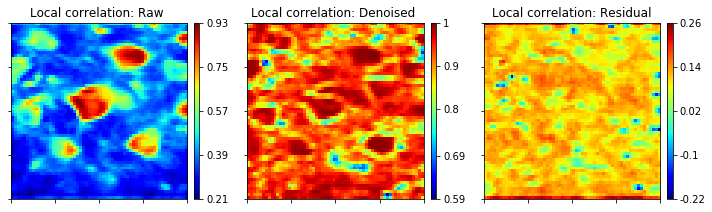

In [10]:
util_plot.comparison_plot([mov, mov_reduced + np.random.randn(np.prod(mov.shape)).reshape(mov.shape)*.01],
                plot_orientation="vertical")

## Render Videos & Residual

In [ ]:
play_cv2(np.vstack([mov, mov_reduced, mov-mov_reduced]), magnification=2)

# Save Results

In [11]:
np.savez(os.path.join(ext, "demo2_results.npz"), U, V, mov_denoised, block_ranks, block_height, block_width)